# Short intro
These code solves the RBC model using projection method. The problem can be desribed as: 
$$
\begin{aligned}
\max_{c_t, k_{t+1}}& E_0 \beta^t \sum^{\infty}_{t=0} \frac{c_t^{1-\nu}}{1-\nu}\\
& wrt:\: c_t+ k_{t+1} =  y_t +(1-\delta)k_t\\
& y_t  = exp(z_t)k^{\alpha}\\
& z_{t+1} = \rho z_t + \epsilon_t\\
&\epsilon_t \sim N(0, \sigma_{\epsilon})
\end{aligned}
$$


In [37]:
using ChebyshevApprox, Polynomials
using NLsolve, Optim, QuantEcon, Plots


In [38]:
#rouwenhorst discretization, I cannot get value of matrix from MarkovChain object, so I print it and then paste it here
# seven points, rho=0.95
ρ = 0.95
σ = 0.007
P =rouwenhorst(7, 0.95, 0.007);
println(P);
PP = [0.8590683010253904 0.13216435400390636 0.00847207397460939 0.00028964355468750076 5.570068359375019e-6 5.712890625000025e-8 2.4414062500000133e-10; 0.022027392333984392 0.8618923256835936 0.11028178344726572 0.00565176269531251 0.00014486938476562536 1.8569335937500063e-6 9.521484375000043e-9; 0.0005648049316406259 0.044112713378906286 0.8635889685058593 0.08828339355468756 0.0033918005371093808 5.794775390625015e-5 3.7133789062500127e-7; 1.4482177734375036e-5 0.001695528808593753 0.06621254516601568 0.8641548876953125 0.06621254516601567 0.001695528808593753 1.4482177734375036e-5; 3.7133789062500127e-7 5.7947753906250145e-5 0.003391800537109381 0.08828339355468756 0.8635889685058593 0.044112713378906286 0.0005648049316406259; 9.521484375000043e-9 1.8569335937500065e-6 0.0001448693847656254 0.00565176269531251 0.11028178344726572 0.8618923256835936 0.022027392333984392; 2.4414062500000133e-10 5.712890625000025e-8 5.570068359375019e-6 0.00028964355468750076 0.00847207397460939 0.13216435400390636 0.8590683010253904];

Discrete Markov Chain
stochastic matrix of type Array{Float64,2}:
[0.8590683010253904 0.13216435400390636 0.00847207397460939 0.00028964355468750076 5.570068359375019e-6 5.712890625000025e-8 2.4414062500000133e-10; 0.022027392333984392 0.8618923256835936 0.11028178344726572 0.00565176269531251 0.00014486938476562536 1.8569335937500063e-6 9.521484375000043e-9; 0.0005648049316406259 0.044112713378906286 0.8635889685058593 0.08828339355468756 0.0033918005371093808 5.794775390625015e-5 3.7133789062500127e-7; 1.4482177734375036e-5 0.001695528808593753 0.06621254516601568 0.8641548876953125 0.06621254516601567 0.001695528808593753 1.4482177734375036e-5; 3.7133789062500127e-7 5.7947753906250145e-5 0.003391800537109381 0.08828339355468756 0.8635889685058593 0.044112713378906286 0.0005648049316406259; 9.521484375000043e-9 1.8569335937500065e-6 0.0001448693847656254 0.00565176269531251 0.11028178344726572 0.8618923256835936 0.022027392333984392; 2.4414062500000133e-10 5.712890625000025e-8 5.5700

In [39]:
#Params with deterministic steady state
ϕ = sqrt(6) * 0.007/(1-0.95);
val = -ϕ:2*ϕ/7:ϕ;
val = exp.(val) #shock values

β=0.95;
ν = 2.0;
δ=0.05;
α=0.33;
k_ss = val[7]*(β*α/(1.0-β*(1.0-δ)))^(1/(1-α));
#lower and upper bound of capital grid
lb=0.1*k_ss;
ub= 3.0*k_ss;


In [40]:
#chebyschev projection


function vf_projection_sg(x,lb, ub, β, ν ,δ, α, P, val)
    # Projection of the consumption and future capital policy functions, to solve first order condition and makret clearing
    #inputs are:
    #1. x :  n times m, n- numbers of productitity shocks, m - 2*a 
    #a - number of polynomials to approximate one policy function for one productivity level
    #2. parameters 
    n = size(x)[1];
    m = size(x)[2];
    a = div(m,2);
    
    # vector of residuals
    residual = zeros(n, 2*a);\
    #nodes: zeros of chebyschev polynomial on [lb, ub] 
    nodes = chebyshev_nodes(a,[lb,ub]);
    # vector to compute expectation in FOC
    c_prim = zeros(n); #for each productivity level k 
    for k in 1:n
        # computation of policy function residuals for one k
        
        #take polynomial combination coordiantes for c(k), k'(k)
        vec_c = x[k,1:a];
        vec_k = x[k,a+1:m];        
        f_c = ChebyshevT(vec_c);
        f_k = ChebyshevT(vec_k);
        p = convert(Polynomial, f_c)
        for i in 1:a
            j = nodes[i];
            
            #get values of c_t and k_{t+1} from policy function, use grid transformation for [-1,1]
            c = max(f_c(2.0*(j-lb)/(ub-lb)-1.0), 1e-6);
            k_prim = max(f_k(2.0*(j-lb)/(ub-lb)-1.0), 1e-7)
            
            y = val[k]*j^(α);
            
            for ss in 1:n #for each next possible productivity level
                if (k_prim<lb || k_prim>ub) #somehow Chebyschew type cannot take values outside [-1,1], 
                    #so I use polynomial representation here
                    
                    r = val[ss]*α*k_prim^(α-1);
                    c_prim[ss] = (β*(1.0+r-δ))*P[k, ss]*max(p(2.0*(k_prim-lb)/(ub-lb)-1.0),1e-7)^(-ν);
                else
                    r = val[ss]*α*k_prim^(α-1);
                    c_prim[ss] = (β*(1.0+r-δ))*P[k, ss]*max(f_c(2.0*(k_prim-lb)/(ub-lb)-1.0), 2e-7)^(-ν);
                end

            end
            #sum expectation of RHS in FOC
            c_prim_exp = sum(c_prim);    
            
            #compute residuals
            residual[k, i] = c^(-ν) - c_prim_exp;
            # last term is to induce positive values of k_prim
            residual[k, i+a] = (k_prim +c - (1.0-δ)*j- y)^2+(f_k(2.0*(j-lb)/(ub-lb)-1.0)-k_prim)^2;
        end
        
    end
        
return(residual);

end



vf_projection_sg (generic function with 1 method)

In [41]:
# transform function, to a function of x
ff(x)= vf_projection_sg(x,lb, ub, β, ν, δ, α, PP, val)


ff (generic function with 1 method)

In [42]:
#Solve easier version of the problem, for only 4 coeffitients for each policy function. 
#STarting vale for consumption  function is from deterministic problem, I found rondom guess for capital work preatty well
#error - value of error
error =1.0
#iteration
i=0.0

n = 7;
m = 8;
sol_vec = zeros(n,m);
x0 = zeros(n, m);

while(abs(error)>=1e-9 && i<=20 )
    #random number
     b= rand(Float64, 1);
     c = rand(Float64, 1);
     d = rand(Float64, 1);
    #guess
    for i in 1:n
        x0[i, 1:m] = vcat([1.6635809557576986, 0.7946731290799368],zeros(2),[val[i]*b[1]*((ub-lb)/2+1),val[i]*c[1]*((ub-lb)/2+1),val[i]*d[1]], zeros(1) )
    end
    sol = nlsolve(ff, x0, iterations =1000, show_trace= false, ftol =1e-12);
    sol_vec = sol.zero;
    error = sum(abs.(ff(sol_vec)));
    println(error)
    i = i+1.0;
end






    

0.13717892818282917
0.13331134402289838
0.03623993904257297
0.21940517304210752
0.12288453458379694
3.3359957999727563e-13


In [43]:
#the same but for full problem, it is long
n = 7;
a = 11;
x0 = zeros(n, 2*a);
i=0;
error=1.0;
sol_vec_2= zeros(n, 2*a)
while(abs(error)>=1e-9 && i<=50)
     b= rand(Float64, 1)
     c = rand(Float64, 1)
     d = rand(Float64, 1)
     #for guess again take random numbers for capital and previous result for consumption pf
     for i in 1:n
        x0[i, 1:a] =vcat(sol_vec[i,1:4],zeros((a-4)));
        x0[i, a+1:2*a] =vcat( val[i]*b[1]*((ub-lb)/2+1),val[i]*c[1]*((ub-lb)/2+1), zeros((a-2)));
    end
    sol = nlsolve(ff, x0, iterations =3000, show_trace= false, ftol =1e-11)
    sol_vec_2 = sol.zero
    error = sum(ff(sol_vec_2))
    println(error)
    i = i+1
end




-3.83157232278113e13
1.0064744695037518e-10


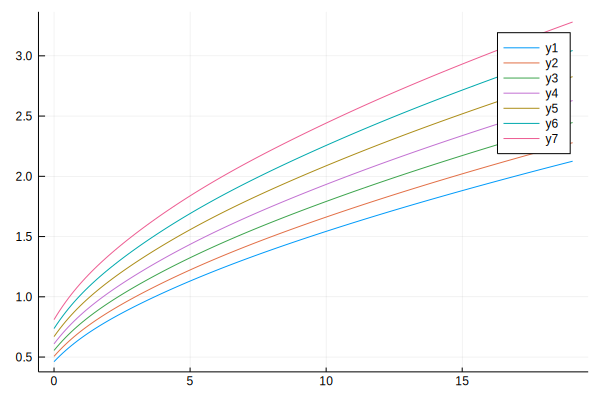

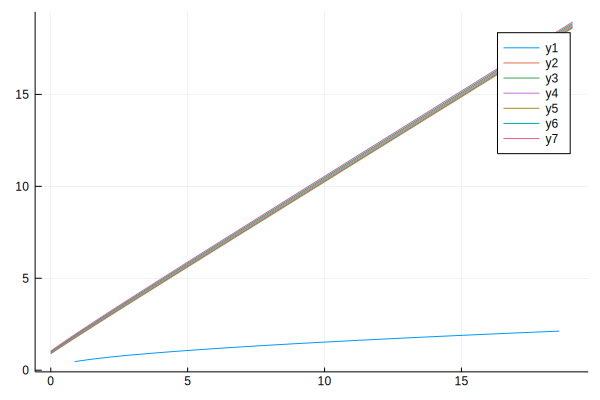

In [44]:
#print policy functions
xs = -1.0:0.01:0.8
a_n = length(xs) 
pf_c = zeros(n, a_n)
pf_k  = zeros(n, a_n)
for i = 1:n 
    f_c = ChebyshevT(sol_vec_2[i,1:a])
    pf_c[i, 1:a_n] = f_c.(xs)
    f_k = ChebyshevT(sol_vec_2[i,a+1:2*a])
    pf_k[i, 1:a_n] = f_k.(xs)
end

xx = (ub-lb)/2.0*(xs.+1.0)

cons = pf_c[1,1:a_n]
plot(xx, cons)
for i in 2:n-1 
    plot!(xx, pf_c[i,1:a_n])
end
display(plot!(xx, pf_c[n,1:a_n]))

#plot(xx, pf_k, title = "future capital policy function", xlabel = "capital")

plot(pf_k[1,1:a_n], cons)
for i in 2:n-1 
    plot!(xx, pf_k[i,1:a_n])
end
display(plot!(xx, pf_k[n,1:a_n]))
